<a href="https://colab.research.google.com/github/tripatheea/auto/blob/main/overfit_signal_one_unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers

from scipy.fft import fft, ifft, fftfreq


!pip install corner

import corner

tfd = tfp.distributions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
sampling_freq = 120
T_duration = 1

N = sampling_freq * T_duration

In [3]:
def generate_signal(sampling_freq=100, T_duration=1, noiseamp=0.000, hamp=5.0, f_sig=8.0):
    
    
    t = np.linspace(0.0, T_duration, sampling_freq * T_duration, endpoint=False)
    Nsample = len(t)
    noise = noiseamp * np.random.normal(0, scale = 1, size = Nsample)
    signal = hamp * np.sin(2 * np.pi * (f_sig * t))

    data = signal + noise
    
    return data

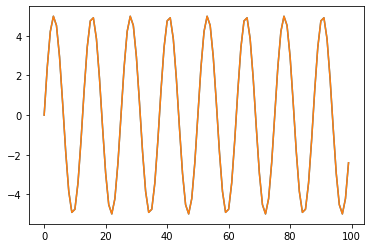

In [4]:
y = generate_signal()

plt.plot(y)
plt.plot(generate_signal())

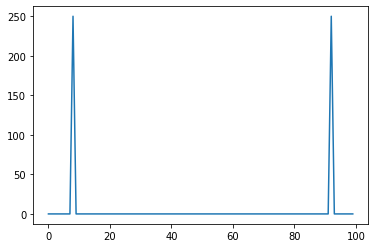

In [5]:
plt.plot(np.abs(fft(y)))

In [180]:
N_data_points = 100

In [181]:
f_s = np.linspace(15, 20, N_data_points)

np.random.shuffle(f_s)

In [182]:
y_s = []
x_s = []
for f in f_s:
    y = generate_signal(sampling_freq=sampling_freq, T_duration=T_duration, noiseamp=0.000000, hamp=100.0, f_sig=f)
    xf = fftfreq(N, 1 / sampling_freq)[:N//2]
    
    fft_y = fft(y)
    
    re = np.array([np.real(a) for a in fft_y])
    im = np.array([np.imag(a) for a in fft_y])
    
    re = (re - np.mean(re)) / np.std(re)
    im = (im - np.mean(im)) / np.std(im)
    
    y_fft = [[f, y_i, r, i] for f, y_i, r, i in zip(xf, y, re, im)]
    y_s.append(y_fft)
    x_s.append([f])

x_s, y_s = np.array(x_s), np.array(y_s)

y_s = y_s.astype(np.float32)
x_s = x_s.astype(np.float32)

x_s.shape, y_s.shape

((100, 1), (100, 60, 4))

18.88889


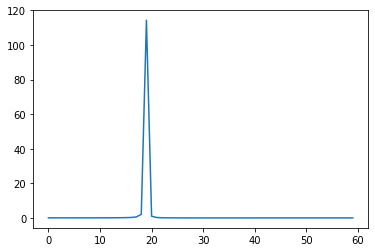

In [183]:
plt.plot(y_s[0,:, 2] * y_s[0,:, 2] + y_s[0,:, 3] * y_s[0,:,3])

print(x_s[0,0])

In [184]:
y_s.shape

(100, 60, 4)

In [185]:
x_s = tf.convert_to_tensor(x_s, dtype=tf.float32)
y_s = tf.convert_to_tensor(y_s, dtype=tf.float32)

In [186]:
x_train = x_s
y_train = y_s

In [187]:
y_train.shape

TensorShape([100, 60, 4])

In [188]:
train_size = 20
batch_size = 4

In [189]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

# train_dataset = (tf.data.Dataset.from_tensor_slices(y_train).shuffle(train_size)).batch(batch_size)
train_dataset = (tf.data.Dataset.from_tensor_slices(y_train)).batch(batch_size)

train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 60, 4), dtype=tf.float32, name=None)>

In [190]:
class SimpleOverFittingCVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, x_dim, y_dim, n_channels, z_dim, n_modes, params):
        super(SimpleOverFittingCVAE, self).__init__()
        self.z_dim = z_dim
        self.n_modes = n_modes
        self.x_modes = 1   # hardcoded for testing
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_channels = n_channels
        self.act = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.params = params
        self.reg = regularizers.l2(0.01)

        """
        # Add this to get rid of regularizer
        a2 = tf.keras.layers.Dense(2*self.z_dim*self.n_modes + self.n_modes)(a2)
        self.encoder = tf.keras.Model(inputs=r1_input_y, outputs=a2)
        print(self.encoder.summary())
        """
        # the r1 encoder network
        r1_input_y = tf.keras.Input(shape=(self.y_dim, self.n_channels, 1))
        # a2 = r1_input_y
        # print("r1 input y shape is", r1_input_y.shape)
        a2 = tf.keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, activation=self.act)(r1_input_y)
        
        # Kernel size is k = 8.
        # Our data is a d x nchannels array.
        # The k = 8 kernel size will hence have d - k + 1 = 50 - 8 + 1 convolutions (for a stride of 1).
        # Hence, the output above will be (d - k + 1) x nfilters hence, (,43, 4).

        a2 = tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, activation=self.act)(a2)
        

        # print("a shape is", a.shape)
        a2 = tf.keras.layers.Flatten()(a2)

        # This flattens everything, so shape will be (, (d - k) + 1) x nfilters) = (, 172) for example.

        
        # a2 = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(a2)

        # # This would give (,32)

        # a2 = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(a2)

        # (,16)

        a2 = tf.keras.layers.Dense(2 * self.z_dim)(a2)  # No activation.
        # 2 * 14 = 28.

        
        self.encoder = tf.keras.Model(inputs=r1_input_y, outputs=a2)
        
        # Conv size is [ (W - K + 2P) / S ] + 1
        # 
        # W is the input volume - in your case 128
        # K is the Kernel size - in your case 5
        # P is the padding - in your case 0 i believe
        # S is the stride - which you have not provided.


        print(self.encoder.summary())

        # # the r2 decoder network
        r2_input_z = tf.keras.Input(shape=(self.z_dim,))

        # # Make this 
        a2 = tf.keras.layers.Dense(7 * 32, activation=self.act)(r2_input_z)

        a2 = tf.keras.layers.Reshape(target_shape=(7, 32))(a2)

        a2 = tf.keras.layers.Conv1DTranspose(
                filters=64, kernel_size=32 , strides=1,
                activation='relu')(a2)        # (7 + 32 - 1 = 38) so (18, 18, 64); (3 + 1 - 1) / 2 = 2.

        a2 = tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=23, strides=1,
                activation='relu')(a2)        # (38 + 23 - 1 = 60) so (60, 64); (4 - 0 + 1) / 1 = 2 / 2 = 3.

        a2 = tf.keras.layers.Conv1DTranspose(
                filters=4, kernel_size=4, strides=1, padding='same')(a2)  # Want this to be (None, 60, 4, 1). Second element needs to be 4.

        
        self.decoder = tf.keras.Model(inputs=r2_input_z, outputs=a2)
        print(self.decoder.summary())
    
    def reparameterize(self, mean, logvar):
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar * .5) + mean

    
    def get_encoders(self):
        return self.encoder
    
    def encode(self, y=None):
        # print("==")
        # print(y)
        # print("AAA")
        # print(self.encoder(y).shape)
        # print(self.encoder(y))Nikon DX VR AF-P NIKKOR 70-300mm 1:4.5-6.3 G ED
#         print([self.z_dim*self.n_modes, self.z_dim*self.n_modes,self.n_modes])
        # print("==")
        # print(self.z_dim*self.n_modes + self.z_dim*self.n_modes + self.n_modes)
        # print(y.shape)
#         mean, logvar, weight = tf.split(self.encoder(y), num_or_size_splits=[2, 4, 3], axis=1)
        mean, logvar = tf.split(self.encoder(y), num_or_size_splits=2, axis=1)
        
#         print(mean)
        return mean, logvar
        # return tf.reshape(mean,[-1,self.n_modes,self.z_dim]), tf.reshape(logvar,[-1,self.n_modes,self.z_dim]), tf.reshape(weight,[-1,self.n_modes])

    def decode(self, z=None, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

In [191]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  # print("Encoding...")
  mean, logvar = model.encode(x)
  # print("Reparameterizing...")
  z = model.reparameterize(mean, logvar)

  # print("z is", z)
  # print("Decoding...")
  x_logit = model.decode(z)
  # print("x shape = ", x.shape, "z shape = ", z.shape, "x_logit shape = ", x_logit.shape)
  # print("Calculating cross entropy...")
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  # print(cross_ent.shape)
  # print("Now getting logpx_z.")
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
  # print("Now getting logpz.")
  logpz = log_normal_pdf(z, 0., 0.)
  # print("Now getting pgqzx.")
  logqz_x = log_normal_pdf(z, mean, logvar)
  # print("Got everything I wanted.")
  # print(type(logpx_z), type(logpz), type(logqz_x))
  # print("logpx_z")
  # print(logpx_z)
  # print("logpz")
  # print(logpz)
  # print("logz_x")
  # print(logqz_x)
  me = -tf.reduce_mean(logpx_z + logpz - logqz_x)
  # print("Got reduced_mean.")
  return me  


In [192]:
train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [193]:

epochs = 10

# start the training loop
train_loss = np.zeros((epochs, 2))
test_loss = np.zeros((epochs, 2))

params = dict()

params['z_dim'] = 14
params['n_modes'] = 3
params['n_channels'] = 4
params['ramp_start'] = 10
params['ramp_end'] = 20
params['y_normscale'] = 1.0

params['rand_pars'] = ['frequency']
params['inf_pars'] = ['frequency']


ramp_start = params['ramp_start']
ramp_length = params['ramp_end']


ramp_cycles = 1
KL_samples = []



model = SimpleOverFittingCVAE(x_dim=3, y_dim=y_s.shape[1], n_channels=params['n_channels'], \
             z_dim=params['z_dim'], n_modes=params['n_modes'], params=params)

model.compile()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 60, 4, 1)]        0         
                                                                 
 conv1d_37 (Conv1D)          (None, 60, 3, 32)         96        
                                                                 
 conv1d_38 (Conv1D)          (None, 60, 2, 64)         4160      
                                                                 
 flatten_20 (Flatten)        (None, 7680)              0         
                                                                 
 dense_39 (Dense)            (None, 28)                215068    
                                                                 
Total params: 219,324
Trainable params: 219,324
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_35"
_____________________________

In [194]:
for a in train_dataset:
  # print(a[3].shape)
  # print(tf.expand_dims(a[0], 0).shape)
  loss = compute_loss(model, tf.expand_dims(a[0], 0))
  # print(a)
  print(loss)

  break

tf.Tensor(37488.305, shape=(), dtype=float32)


In [195]:
for t in train_dataset:
  # print(t)
  break

In [196]:
epochs = 10
optimizer = tf.keras.optimizers.Adam(1e-4)

all_losses = []

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    # for step, x_batch_train in enumerate(train_x):
      # train_x = tf.expand_dims(train_x[0], 0)
    train_step(model, train_x, optimizer)
  
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in train_dataset:        # Should be test_dataset.
    # test_x = tf.expand_dims(test_x, 0)
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  all_losses.append(elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  # generate_and_save_images(model, epoch, test_sample)


Epoch: 10, Test set ELBO: 1200096256.0, time elapse for current epoch: 0.20227837562561035


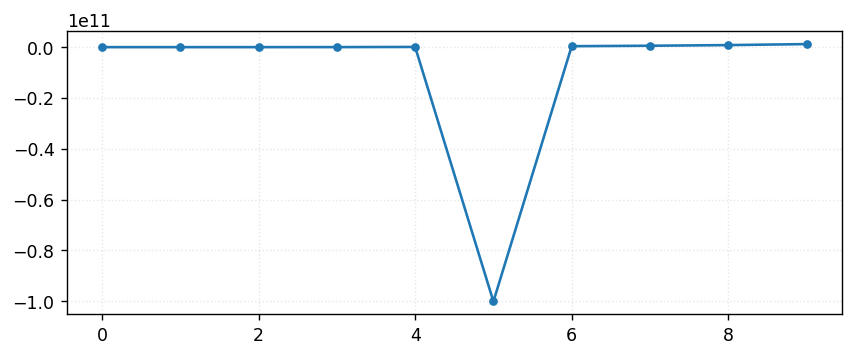

In [198]:
plt.figure(figsize=(8, 3), dpi=125)

plt.plot(np.arange(epochs), all_losses, marker="o", ms=4)

plt.grid(alpha=0.3, ls="dotted")

In [ ]:
6np.array()

TypeError: ignored

In [ ]:
a = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(14 + 14),
        ]
    )

b = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(14,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )


In [ ]:
a.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 13, 13, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten_58 (Flatten)        (None, 2304)              0         
                                                                 
 dense_172 (Dense)           (None, 28)                64540     
                                                                 
Total params: 83,356
Trainable params: 83,356
Non-trainable params: 0
_________________________________________________________________


In [ ]:
b.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_173 (Dense)           (None, 1568)              23520     
                                                                 
 reshape_59 (Reshape)        (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                      